In [1]:
import numpy as np
import random

from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from tqdm import tqdm
from tqdm import trange
import time

import os
import math
from math import sin
from icecream import ic
import json
import argparse

# checklist 1: uncomment matplotlib.use('Agg')
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.gridspec as gridspec
# plt.rcParams["font.family"] = "Times New Roman"
%matplotlib inline  

# plt.style.use('dark_background')

from scipy.io import loadmat
import scipy
from scipy import signal
from scipy.fftpack import fft, ifft
from scipy.signal import hilbert, chirp
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

i_seed = 0

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
from torchsummary import summary

import PIL

import sys

sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from plotting_tools import *
# from preprocessing import *
# from feature_extraction import *
# from data_pulling import *
# from setting import *
# from surrogate_extraction import *
# from evaluate import *
# from training_util import *
# from dataset_util import *
# from evaluation_util import *

from plotting_tools import *
from preprocessing import *
from setting import *
from surrogate_extraction import *
from dataIO import *
from filters import *
from spectral_module import *
from stage4_regression import *
# from unet_extension.dataset_util import *
# from unet_extension.evaluation_util import *
# from unet_extension.models import *
# from unet_extension.training_util import *


import datetime
import time

# checklist 2: comment out all magic command
from importlib import reload
%load_ext autoreload
%autoreload 2


/home/mchan/miniconda3/envs/mienv/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.11) or chardet (2.1.1) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# Fs = FS_RESAMPLE

# label_names = ['br', 'heart_rate_cosmed', 'rer', 'vco2_ml_min', 've', 'vo2_ml_min', 'vt']
# sig_names = ['ECG', 'accelX', 'accelY', 'accelZ']

In [3]:
parser = argparse.ArgumentParser(description='RR_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--training_params_file', metavar='training_params_file', help='training_params_file',
                    default='training_params_list.json')


# checklist 3: comment first line, uncomment second line
# args = parser.parse_args(['--input_folder', '../../../covid/results/stage3/win60_overlap95_seq20_ECG_AMpt_norm_script1/', 
args = parser.parse_args(['--input_folder', '../../data/stage4_UNet/', 
# args = parser.parse_args(['--input_folder', '../../data/stage4_UNet_backup/', 
                          '--output_folder', '../../data/stage5_UNet/'])
                          
# args = parser.parse_args()
print(args)

Namespace(input_folder='../../data/stage4_UNet/', output_folder='../../data/stage5_UNet/', training_params_file='training_params_list.json')


In [4]:
inputdir = args.input_folder
outputdir = args.output_folder
# outputdir = outputdir+inputdir.split('/')[-2]+'/'

# training_params_file = args.training_params_file

In [5]:
steps_thre = 50
# list_modalitites = ['SCG', 'PPG', 'ECG', 'SCGPPG', 'ECGSCG', 'ECGPPG', 'All']

# list_modalitites = ['SCG-select',
#                     'ECG-SR+SCG-select',
#                     'ECG-SR',
#                     'PPG-select',
#                     'SCG-select+PPG-select',
#                     'ECG-SR+PPG-select',
#                     'ECG-SR+SCG-select+PPG-select',
#                     'ECG-SR+PPG']
list_modalitites = ['ECG-SR+PPG-select']


# list_TF_types = ['source', 'FT_top', 'FT_top2', 'FT_all', 'target']


# list_modalitites = ['PPG', 'ECG', 'SCG']

# list_method = ['ST', 'U-Net']
# list_method = ['ST', 'U-Net', 'U-Net RQI_fft', 'U-Net RQI_kurtosis']
# list_method = ['ST', 'U-Net', 'U-Net-SE_block', 'ST RQI_kurtosis', 'U-Net RQI_kurtosis', 'U-Net-SE_block RQI_kurtosis', 'U-Net-SE_block RQI_fft']
# list_method = ['ST', 'U-Net', 'U-Net-SE_block', 'ST RQI_kurtosis', 'U-Net RQI_kurtosis', 'U-Net RQI_fft']
# list_method = ['ST', 'U-Net', 'ST RQI_fft', 'U-Net RQI_fft']
# list_method = ['ST', 'ST RQI_fft','U-Net-AT_block', 'U-Net-AT_block RQI_fft']
list_method = ['ST', 'ST RQI_fft', 'U-Net', 'U-Net RQI_fft', 'U-Net-AT_block', 'U-Net-AT_block RQI_fft']

list_TF_types = ['source', 'target']
# list_TF_types = ['pretrain', 'source', 'target']
domain_name = 'CDC_dataset'
# domain_name = 'GT_dataset'
act_type = 'walk'

# all act
# array([ 0.,  2.,  1.,  3.,  4.,  5.,  6., 10.])

if act_type=='rest':
#     reject_act = [1, 2, 3, 4, 5, 6, 10] # keep 0
    task_ids = [0]

elif act_type=='6MWT':
#     reject_act = [0 ,1, 2, 3, 4, 5, 10] # keep 6
    task_ids = [6]

elif act_type=='Run':
#     reject_act = [0 ,1, 2, 3, 4, 5, 6] # keep 10
    task_ids = [10]

elif act_type=='ER':
#     reject_act = [0, 6, 10] # keep 1, 2, 3, 4
    task_ids = [1,2,3,4,5]

elif act_type=='stationary':
#     reject_act = [6, 10] # keep 1, 2, 3, 4
    task_ids = [0,1,2,3,4,5]
    
elif act_type=='walk':
    task_ids = [6,7,9]
# act_type = 'ER'
# # act_type = 'rest'
# act_type = '6MWT'

# if act_type=='rest':
#     reject_act = [1, 2, 3, 4, 5, 6, 10] # keep 0
# elif act_type=='6MWT':
#     reject_act = [0 ,1, 2, 3, 4, 5, 10] # keep 6
# elif act_type=='Run':
#     reject_act = [0 ,1, 2, 3, 4, 5, 6] # keep 6
# elif act_type=='ER':
#     reject_act = [0, 6, 10] # keep 1, 2, 3, 4
# # reject_act = [0, 1, 2, 3, 4, 5]
# # reject_act = [1, 2, 3, 4, 5, 6]
# # reject_act = [1]

In [6]:
act_type

'walk'

In [7]:
variant = 'baseline'
# list_variants = ['baseline', 'SE_block']
# list_variants = ['baseline']
# list_variants = ['baseline', 'AT_block']
list_variants = ['AT_block']

# variant = 'SE_block'

In [8]:
# inputdir

In [9]:
if domain_name=='GT_dataset':

    home = expanduser("~")

    filename_subinfo = home+'/'+ 'Estimation_RR/covid/Mobashir_CosmedWearable/Cosmed Wearable Subject Information.xlsx'
    df_subinfo = pd.read_excel(filename_subinfo) 
    df_subinfo

    df_subinfo = df_subinfo.rename(columns={'Height in cm': 'Height', 'Weight in Kg': 'Weight', 'Subject ID':'Subject_ID'})

    df_subinfo['Subject_ID'] = df_subinfo['Subject_ID'].apply(lambda x: int(x.split('M')[0].split('F')[0].split('CW')[1]))
    df_subinfo = df_subinfo[['Subject_ID', 'Age', 'Height', 'Weight', 'Gender']].drop_duplicates().reset_index(drop=True)
    df_subinfo['BMI'] = df_subinfo['Weight'].values / (df_subinfo['Height'].values/100)**2
    df_subinfo['Fitzpatrick'] = -1
    
elif domain_name=='CDC_dataset':

    filename_subinfo = '../../data/raw/FS Subject Information.xlsx'
    df_subinfo = pd.read_excel(filename_subinfo, sheet_name='Subject info') 

    i_sub_last = np.where(df_subinfo['Subject_ID'].isnull()==True)[0][0]
    df_subinfo = df_subinfo[:i_sub_last]

    df_subinfo = df_subinfo[['Subject_ID', 'Age', 'Height(cm)', 'Weight(Kg)', 'Gender(0=Male,1=Female)', 'Fitzpatrick', '6MWT distance (m)', '6MWT-R distance (m)', 'Fitzpatrick']]
    df_subinfo = df_subinfo.rename(columns={'Height(cm)': 'Height', 'Weight(Kg)': 'Weight', 'Gender(0=Male,1=Female)': 'Gender'})
    df_subinfo['BMI'] = df_subinfo['Weight'].values / (df_subinfo['Height'].values/100)**2
    df_subinfo['Subject_ID'] = df_subinfo['Subject_ID'].astype(int)
    

In [10]:
df_subinfo

,Subject_ID,Age,Height,Weight,Gender,Fitzpatrick,6MWT distance (m),6MWT-R distance (m),Fitzpatrick,BMI
0,101,26.0,172.00,90.00,1,2.0,286.500,264.550,2.0,30.421850
1,102,30.0,177.80,75.00,1,2.0,280.720,272.090,2.0,23.724537
2,103,29.0,174.00,70.00,1,2.0,302.100,289.380,2.0,23.120624
3,104,21.0,185.40,79.30,1,1.0,302.460,290.840,1.0,23.070326
4,105,21.0,177.80,68.00,1,1.0,311.200,303.960,1.0,21.510247
5,106,28.0,178.00,76.00,1,1.0,408.000,379.080,1.0,23.986870
6,107,27.0,194.00,90.72,1,1.0,296.150,288.680,1.0,24.104581
7,108,24.0,180.34,70.76,1,2.0,240.240,209.770,2.0,21.757235
8,109,21.0,160.02,52.16,2,2.0,578.900,537.029,2.0,20.369907
9,110,22.0,182.88,93.00,1,3.0,578.760,574.140,3.0,27.806769


In [11]:
# # this function computes the threshold for RQI (defined as the value requires to get MAE<1BPM)
#     RQI_name = 'RQI_kurtosis'

#     df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
#     i_RQI_threshold = np.argmin(np.abs(df_RQI_results['coverage'].values-95))
#     RQI_threshold = df_RQI_results.loc[i_RQI_threshold,:]['threshold']

# return RQI_threshold

# # MAE_diff = df_RQI_results['MAE'].values-1
# # #     MAE_diff = df_RQI_results['MAE'].values-1
# # df_RQI_results['MAE_diff'] = MAE_diff

# # #     print(df_RQI_results['coverage'].min(), df_RQI_results['coverage'].max())
# # #     sys.exit()

# # #     print(MAE_diff)

# # # if MAE for not all thresholds is less than 1
# # if (MAE_diff<0).sum()!=0:
# #     # find all indices where MAE_diff < 0 and MAE_diff = maximum MAE
# #     # this implies finding the largest threshold to reject data (large is better because we can maximize coverage)
# #     i_RQI_threshold = np.where((MAE_diff<0) & (MAE_diff==MAE_diff[MAE_diff<0].max()))[0]
# #     # pick any one (the last one then)
# #     i_RQI_threshold = i_RQI_threshold[-1]
# #     # set the threshold to this value
# #     RQI_threshold = df_RQI_results.loc[i_RQI_threshold,:]['threshold']
# # # if MAE for all thresholds is less than 1
# # else:        
# #     if RQI_name == 'RQI_fft':
# #         RQI_threshold=0.55
# #     elif RQI_name == 'RQI_kurtosis':
# #         RQI_threshold=0

In [12]:
# df_outputlabel

In [13]:
def get_RQI_threshold(df_outputlabel, RQI_name, steps_thre=10):
    # this function computes the threshold for RQI (defined as the value requires to get MAE<1BPM)
    df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
#     MAE_diff = df_RQI_results['MAE'].values-1
#     MAE_diff = df_RQI_results['MAE'].values-1
#     df_RQI_results['MAE_diff'] = MAE_diff
    
    coverage_thre = 97

    df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
    i_RQI_threshold = np.argmin(np.abs(df_RQI_results['coverage'].values-coverage_thre))
    RQI_threshold = df_RQI_results.loc[i_RQI_threshold,:]['threshold']

    return RQI_threshold


def get_RQI_threshold2(df_outputlabel, RQI_name, steps_thre=10):
    # this function computes the threshold for RQI (defined as the value requires to get MAE<1BPM)
#     coverage_thre = 97

#     df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
#     i_RQI_threshold = np.argmin(np.abs(df_RQI_results['coverage'].values-coverage_thre))
#     RQI_threshold = df_RQI_results.loc[i_RQI_threshold,:]['threshold']
    
    # the lowest 10%
    RQI_threshold = np.percentile(df_outputlabel[RQI_name].values, 20)

    return RQI_threshold



def get_RQI_threshold1(df_outputlabel, RQI_name, steps_thre=10):
    # this function computes the threshold for RQI (defined as the value requires to get MAE<1BPM)
    df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
#     MAE_diff = df_RQI_results['MAE'].values-1
    MAE_diff = df_RQI_results['MAE'].values-1.5
#     MAE_diff = df_RQI_results['MAE'].values-1
    df_RQI_results['MAE_diff'] = MAE_diff
    
#     print(df_RQI_results['coverage'].min(), df_RQI_results['coverage'].max())
#     sys.exit()
    
    # if MAE for not all thresholds is less than 1
    if (MAE_diff<0).sum()!=0:
        # find all indices where MAE_diff < 0 and MAE_diff = maximum MAE
        # this implies finding the largest threshold to reject data (large is better because we can maximize coverage)
        i_RQI_threshold = np.where((MAE_diff<0) & (MAE_diff==MAE_diff[MAE_diff<0].max()))[0]
        # pick any one (the last one then)
        i_RQI_threshold = i_RQI_threshold[-1]
        # set the threshold to this value
        RQI_threshold = df_RQI_results.loc[i_RQI_threshold,:]['threshold']
    # if MAE for all thresholds is less than 1
    else:        
        if RQI_name == 'RQI_fft':
            RQI_threshold=0.55
        elif RQI_name == 'RQI_kurtosis':
            RQI_threshold=0

#         i_RQI_threshold = MAE_diff.shape[0]//2
        
#     RQI_threshold = df_RQI_results.loc[i_RQI_threshold,:]['threshold'].values

    # i_RQI_threshold/ 
#     return RQI_threshold
    return RQI_threshold

In [14]:
# data = df_outputlabel['RQI_kurtosis'].values
# # k = 10
# # idx = np.argpartition(aaa, k)
# # the lowest 10%
# value_low = np.percentile(data, 10)
# # indices_CI = np.where((data<=value_up) & (data>=value_lw))[0]

In [15]:

def get_mask_random(N_zeros, N_ones, i_seed=0):
    # create a mask with N_zeros and N_ones
    # default seed is 0
    mask_random = [0] * N_zeros + [1] * N_ones
    random.seed(i_seed)
    random.shuffle(mask_random)
    mask_random = np.asarray(mask_random).astype(bool)
    return mask_random

def get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=10):
    
    df_RQI_results = pd.DataFrame()

    label = df_outputlabel['label'].values
    label_est = df_outputlabel['label_est'].values

    if RQI_name!='random':
        RQI_range = df_outputlabel[RQI_name].min(), df_outputlabel[RQI_name].max()
    else:
        RQI_range = [0,df_outputlabel.shape[0]]
        
        
    for threshold in np.linspace(RQI_range[0],RQI_range[1],steps_thre, endpoint=False):
#     for threshold in np.linspace(0,1,steps_thre, endpoint=True):
# np.linspace(0,1,steps_thre, endpoint=True)
        if RQI_name!='random':
            mask_RQI = df_outputlabel[RQI_name] > threshold
#             MAE, _ = get_MAE(label[mask_RQI], label_est[mask_RQI])
        else:
            # random rejection
            N_zeros = int(threshold)
            N_ones = df_outputlabel.shape[0] - N_zeros
            mask_RQI = get_mask_random(N_zeros, N_ones)
        
        MAE, _ = get_MAE(label[mask_RQI], label_est[mask_RQI])

        df_RQI_results = df_RQI_results.append(
            pd.DataFrame(
                {
                    'threshold': threshold,
                    'coverage': mask_RQI.mean()*100,
                    'MAE': MAE,
                    'N_subs': df_outputlabel['CV'][mask_RQI].unique().shape[0],
                }, index=[0]
        ))

    df_RQI_results = df_RQI_results.reset_index(drop=True)
    return df_RQI_results

In [16]:
# np.linspace(0,1,steps_thre, endpoint=True)

# get train data, compute threshold for RQI

In [17]:
# # Estimation_EE/data/stage4_UNet/ECG/win60_overlap95_seq20_norm/target
# csv_dir
# sub_file

In [18]:
# os.listdir(inputdir+domain_name)


In [19]:

df_outputlabel_ALL_train = pd.DataFrame()

# for sub_file in os.listdir(inputdir):
#     if '.ipynb_checkpoints'==sub_file:
#         continue
        
for modalitity in list_modalitites:
        
    for TF_type in list_TF_types:
        
        for variant in list_variants:
        
    #         modalitity = sub_file

            csv_dir = inputdir + domain_name + '/' + modalitity + '/{}/{}/numeric_results/df_outputlabel_train_RR_cosmed.csv'.format(variant, TF_type)
            try:
                df_outputlabel_train_RR_cosmed = pd.read_csv(csv_dir)  
            except:
                print(modalitity, 'directory does not exist:', csv_dir)
                continue
            df_outputlabel_train_RR_cosmed['RQI_ideal'] = -np.abs(df_outputlabel_train_RR_cosmed['label_est'] - df_outputlabel_train_RR_cosmed['label'])

            df_outputlabel_train_RR_cosmed['modality'] = modalitity
            
#             if variant=='SE_block':
            if 'block' in variant:
                df_outputlabel_train_RR_cosmed['est_method'] = 'U-Net-' + variant
            else:
                df_outputlabel_train_RR_cosmed['est_method'] = 'U-Net'
            df_outputlabel_train_RR_cosmed['TF_type'] = TF_type

            df_outputlabel_ALL_train = df_outputlabel_ALL_train.append(df_outputlabel_train_RR_cosmed)

In [20]:
df_outputlabel_ALL_train['activity'].unique()

array([0., 1., 2., 3., 4., 5.])

In [21]:
# df_RQI_threshold

In [22]:
df_RQI_threshold = pd.DataFrame()


for CV in df_outputlabel_ALL_train['CV'].unique(): 
    for modality in df_outputlabel_ALL_train['modality'].unique():
        for TF_type in df_outputlabel_ALL_train['TF_type'].unique():
            for est_method in df_outputlabel_ALL_train['est_method'].unique():
                df_outputlabel = df_outputlabel_ALL_train[(df_outputlabel_ALL_train['CV']==CV) & (df_outputlabel_ALL_train['modality']==modality) & (df_outputlabel_ALL_train['TF_type']==TF_type) & (df_outputlabel_ALL_train['est_method']==est_method)]

                
                if df_outputlabel.shape[0]==0:
                    continue
                RQI_fft_threshold = get_RQI_threshold(df_outputlabel, 'RQI_fft', steps_thre=steps_thre)
                RQI_kurtosis_threshold = get_RQI_threshold(df_outputlabel, 'RQI_kurtosis', steps_thre=steps_thre)

                df_RQI_threshold = df_RQI_threshold.append(
                    pd.DataFrame(
                        {
                            'CV': CV,
                            'modality': modality,
                            'TF_type': TF_type,
                            'est_method': est_method,
                            'RQI_fft_threshold': RQI_fft_threshold,
                            'RQI_kurtosis_threshold': RQI_kurtosis_threshold,
                        }, index=[0]
                    )
                )


In [23]:
TF_type

'target'

In [24]:
# RQI_fft_threshold, RQI_kurtosis_threshold

# get val data

In [25]:
df_outputlabel_ALL = pd.DataFrame()
   
for modalitity in list_modalitites:
        
    for TF_type in list_TF_types:
        
        for variant in list_variants:

    #         csv_dir = inputdir + sub_file + '/win60_overlap95_seq20_norm/numeric_results/df_outputlabel_val_RR_cosmed.csv'
            csv_dir = inputdir + domain_name + '/' +  modalitity + '/{}/{}/numeric_results/df_outputlabel_val_RR_cosmed.csv'.format(variant, TF_type)

            try:
                df_outputlabel_val_RR_cosmed = pd.read_csv(csv_dir)  
            except:
                print(modalitity, 'directory does not exist')
                continue
    #         df_outputlabel_val_RR_cosmed = pd.read_csv(csv_dir)  
            df_outputlabel_val_RR_cosmed['RQI_ideal'] = -np.abs(df_outputlabel_val_RR_cosmed['label_est'] - df_outputlabel_val_RR_cosmed['label'])

    #         csv_dir = inputdir + sub_file + '/win60_overlap95_seq20_norm/numeric_results/df_outputlabel_val_input_RR_cosmed.csv'
            csv_dir = inputdir + domain_name + '/' + modalitity + '/{}/{}/numeric_results/df_outputlabel_val_input_RR_cosmed.csv'.format(variant, TF_type)

            try:
                df_outputlabel_val_input_RR_cosmed = pd.read_csv(csv_dir)  
            except:
                print(modalitity, 'directory does not exist')
                continue

            df_outputlabel_val_input_RR_cosmed['RQI_ideal'] = -np.abs(df_outputlabel_val_input_RR_cosmed['label_est'] - df_outputlabel_val_input_RR_cosmed['label'])

            df_outputlabel_val_input_RR_cosmed['modality'] = modalitity
            df_outputlabel_val_input_RR_cosmed['est_method'] = 'ST'
            df_outputlabel_val_input_RR_cosmed['TF_type'] = TF_type


            df_outputlabel_val_RR_cosmed['modality'] = modalitity
            

#             if variant=='SE_block':
            if 'block' in variant:
                df_outputlabel_val_RR_cosmed['est_method'] = 'U-Net-' + variant
            else:
                df_outputlabel_val_RR_cosmed['est_method'] = 'U-Net'
#             df_outputlabel_val_RR_cosmed['est_method'] = 'U-Net'
            df_outputlabel_val_RR_cosmed['TF_type'] = TF_type

            df_outputlabel_ALL = df_outputlabel_ALL.append(df_outputlabel_val_input_RR_cosmed)
            df_outputlabel_ALL = df_outputlabel_ALL.append(df_outputlabel_val_RR_cosmed)

In [26]:
df_outputlabel_ALL['activity'].unique()

array([ 0.,  2.,  1.,  3.,  4.,  5.,  6.,  7.,  9., 10.])

In [27]:
# mask_set = ~np.isin(df_outputlabel_ALL['activity'].values, reject_act)
# df_outputlabel_ALL = df_outputlabel_ALL[mask_set]
# df_outputlabel_ALL['activity'].unique()

In [28]:
mask_task = np.in1d(df_outputlabel_ALL['activity'].values, np.asarray(task_ids))
df_outputlabel_ALL = df_outputlabel_ALL[mask_task]
df_outputlabel_ALL['activity'].unique()


array([6., 7., 9.])

In [29]:
def get_best_estimates(matrix_modality):

    df_matrix = []
    for i, key in enumerate(matrix_modality):
        df_matrix.append(matrix_modality[key].values)

    df_matrix = np.stack(df_matrix).transpose(1,0,2) # number of samples x number of modalities x number of columns
#     print(df_matrix.shape)

    i_RQI = list(df_outputlabel.columns).index('RQI_kurtosis')
#     i_RQI = list(df_outputlabel.columns).index('RQI_fft')
    i_best_modalities = np.argmax(df_matrix[:,:,i_RQI], axis=1)
#     print(i_best_modalities)
    df_matrix = df_matrix[np.arange(i_best_modalities.shape[0]), i_best_modalities, :]

    df_matrix = pd.DataFrame(df_matrix, columns=list(df_outputlabel.columns))
#     print(df_matrix)
#     df_matrix['RQI_fft'] = -1
#     df_matrix['RQI_ideal'] = -np.abs(df_matrix['label_est'] - df_matrix['label'])
#     df_matrix['modality'] = 'select_' + df_matrix['modality'].astype(str)
    df_matrix['modality'] = 'selected'
#     print(df_matrix)

    return df_matrix

# add an additional moadility: ``selected``
# this may be better than using all (not true)

In [30]:

if 'U-Net-AT_block' not in df_outputlabel_ALL['est_method'].unique():
    
    if 'U-Net-SE_block' not in df_outputlabel_ALL['est_method'].unique():

        df_outputlabel_selected = []

        matrix_modality = {}
        for modality in df_outputlabel_ALL['modality'].unique():
        #     for modality in ['ECG', 'PPG', 'SCG']:
        #         for TF_type in df_outputlabel_ALL_train['TF_type'].unique():
        #     df_outputlabel = df_outputlabel_ALL[(df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['CV']==subject_id)]
            df_outputlabel = df_outputlabel_ALL[(df_outputlabel_ALL['modality']==modality)]
        #     print(df_outputlabel.shape)
            matrix_modality[modality] = df_outputlabel
        df_matrix = get_best_estimates(matrix_modality)
        # sys.exit()
        df_outputlabel_selected.append(df_matrix)
        df_outputlabel_selected = pd.concat(df_outputlabel_selected)


In [31]:
include_selected = False
if include_selected:
    df_outputlabel_ALL_selected = pd.concat([df_outputlabel_ALL, df_outputlabel_selected])
    print(df_outputlabel_selected.shape, df_outputlabel_ALL.shape, df_outputlabel_ALL_selected.shape)
else:
    df_outputlabel_ALL_selected = df_outputlabel_ALL
    print(df_outputlabel_ALL.shape, df_outputlabel_ALL_selected.shape)



(16004, 14) (16004, 14)


In [32]:
df_outputlabel_ALL_selected['CV'].unique().shape

(17,)

In [33]:
df_outputlabel_ALL_selected['est_method'].unique()

array(['ST', 'U-Net-AT_block'], dtype=object)

In [34]:
# aggregate estimated to get performance for each modality, TF_type, est_method, subject_id

In [35]:
def get_df_performance_agg(df_outputlabel_ALL):
    # agg information across modality (ECG, SCG, ...), TF_type (pretrain, source, target), subject_id
    
    df_performance_agg = pd.DataFrame()

    for modality in df_outputlabel_ALL['modality'].unique():
        for TF_type in df_outputlabel_ALL['TF_type'].unique():

            for est_method in list_method:
                
#                 for task_id in df_outputlabel_ALL['activity'].unique():
        
                task_id = 0
        
                for subject_id in df_outputlabel_ALL['CV'].unique():

                    # this condition is for est_method=ST or est_method=U-Net
                    if 'RQI' not in est_method:
#                         mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['activity']==task_id) & (df_outputlabel_ALL['CV']==subject_id)
                        mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['CV']==subject_id)
                        if mask_df.sum()==0:
#                                 print('mask_df is empty')
#                                 print(modality, TF_type, est_method, task_id, subject_id, coverage)
                            continue
                        df_outputlabel = df_outputlabel_ALL[mask_df]
            #             MAE_mean, MAE_std = get_MAE(df_outputlabel['label'], df_outputlabel['label_est'])
                        coverage = 100


                    # consider RQI, reject samples accordingly
                    else:
#                         mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method.split(' ')[0]) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['activity']==task_id) & (df_outputlabel_ALL['CV']==subject_id)
                        mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method.split(' ')[0]) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['CV']==subject_id)
                        if mask_df.sum()==0:
#                                 print('mask_df is empty')
#                                 print(modality, TF_type, est_method, task_id, subject_id, coverage)
                            continue
                        df_outputlabel = df_outputlabel_ALL[mask_df]
        #                 sys.exit()

                        mask_RQI = (df_RQI_threshold['modality']==modality) & (df_RQI_threshold['TF_type']==TF_type)

                        # df_RQI_threshold may not contain modality ``selected``, skip it
                        if mask_RQI.sum()==0:
                            continue
                        df_outputlabel= df_outputlabel.merge(df_RQI_threshold[mask_RQI], on=['CV'])
        #                 df_outputlabel= df_outputlabel.merge(df_RQI_threshold, on=['CV'])


                        RQI_name = est_method.split(' ')[1]
                        RQI_mask = df_outputlabel[RQI_name] > df_outputlabel[RQI_name+'_threshold']
        #                 sys.exit()
                        df_outputlabel = df_outputlabel[RQI_mask]
                        coverage = RQI_mask.mean()*100

#                             if coverage==0:
#                                 print(modality, TF_type, est_method, task_id, subject_id, coverage)

                    if coverage==0:
                        
                        print('{}: coverage=0'.format(subject_id))
                        continue


#                         if df_outputlabel.shape[0]==0:
#                             print( mask_df.sum() )
#                             print(modality, TF_type, est_method, task_id, subject_id, coverage)
#                             print(RQI_mask.sum())
#                             print(df_outputlabel)
#                             print( get_RMSE(df_outputlabel['label'], df_outputlabel['label_est']))


                    MAE_mean, MAE_std = get_MAE(df_outputlabel['label'], df_outputlabel['label_est'])
#                     PCC = get_PCC(df_outputlabel['label'], df_outputlabel['label_est'])
#                     CoeffDeterm = get_CoeffDeterm(df_outputlabel['label'], df_outputlabel['label_est'])
                    MAPE, _ = get_MAPE(df_outputlabel['label'], df_outputlabel['label_est'])
                    RMSE = get_RMSE(df_outputlabel['label'], df_outputlabel['label_est'])

                    one_dict = {
                        'MAE_mean': MAE_mean,
                        'MAE_std': MAE_std,
#                         'PCC': PCC,
#                         'CoeffDeterm': CoeffDeterm,
                        'MAPE': MAPE*100,
                        'RMSE': RMSE,
                        'method': est_method,
                        'modality': modality,
                        'TF_type': TF_type,
                        'coverage': coverage,
                        'task': tasks_dict_reversed[task_id],
                        'subject_id': subject_id
                    }

                    df_performance_agg = df_performance_agg.append(one_dict, ignore_index=True)

    return df_performance_agg

In [36]:
df_performance_agg_joint = get_df_performance_agg(df_outputlabel_ALL_selected)

In [37]:
# modality = 'ECG'
# est_method = 'U-Net'
# TF_type = 'target'
# # task_id = 0
# subject_id = 106

# mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['CV']==subject_id)
# plt.scatter(df_outputlabel_ALL[mask_df]['label'].values, df_outputlabel_ALL[mask_df]['label_est'].values)

In [38]:
# df_outputlabel_ALL['CV'].unique()


In [39]:
# df_performance_agg_joint['method'].unique()

In [40]:
hue_color_dict = {
    'ST': '#F5F4E0',
    'ST RQI_fft': '#928462',

    'source': '#D8D7C5',
    'target': '#B8B7A9',

    
    
    'U-Net': '#B8B7A9',
    'U-Net RQI_fft': '#6A7E7B',
    
    'U-Net source': '#D8D7C5',
    'U-Net target': '#B8B7A9',
    


    'U-Net-AT_block':'#F696A6' ,
    'U-Net-AT_block RQI_fft':'#C4580C' ,
    
    'U-Net-AT_block source': '#E2C3BC',
    'U-Net-AT_block target': '#F696A6',

#     'source': '#F5F4E0',
#     'target': '#D8D7C5',
#     'pretrain': '#B8B7A9',
}


In [41]:
def plot_hue_compare(df, plt_scale=1.5,  x_name='modality', y_name='MAE_mean', hue_name='hue_name', metric_name='MAE_mean', ylims=None, order_list=None, hue_order=None, fig_name=None, show_plot=False, outputdir=None, log_wandb=False, verbose=False):
#     metric_name = 'MAE_mean'
    
    if hue_order is None:
         hue_order=list(hue_color_dict.keys())

    fig, ax = plt.subplots(1,1, figsize=(5*plt_scale,5),dpi=250)
    fontsize=7
    
#     sns.violinplot(x="modality", y=metric_name, hue="TF_type", data=df, ax=ax, palette=TF_color_dict)
    sns.boxplot(x=x_name, y=y_name, hue=hue_name, data=df, ax=ax, palette=hue_color_dict, hue_order=hue_order,
                showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"5"},
             order = order_list
               )
    ax.tick_params(labelsize=fontsize)


#     sns.swarmplot(x="modality", y=metric_name, hue="TF_type", data=df, ax=ax, color='black', hue_order=list(TF_color_dict.keys()), dodge=True, size=3, alpha=0.8)

    # get the lowest MAE
#     MAE_lowest = []
    df_MAEs = []
    for hue_name in df['hue_name'].unique():
        for modality in df['modality'].unique():
            mean_MAE = df[(df['modality']==modality) & (df['hue_name']==hue_name)][metric_name].mean() 
            if math.isnan(mean_MAE):
                continue
            mae_dict ={
                'hue_name': hue_name,
                'modality': modality,
                'mean_MAE': mean_MAE,
            }
            
            df_MAEs.append( mae_dict )
            
    df_MAEs = pd.DataFrame(df_MAEs)
#     print(df_MAEs)
#     print(df[['mean_MAE']].idxmin())
#     sys.exit()
    i_min = df_MAEs[['mean_MAE']].idxmin().values[0]

    hue_name, modality, MAE_lowest =  df_MAEs.iloc[i_min,:].values
#     hue_name, modality, MAE_lowest
    
#     MAE_lowest = min(MAE_lowest)
    
    
    
    # xmin and xmax 
    xmin = -.8
    xmax = df['modality'].unique().shape[0]-1+0.8
    ax.hlines(y=MAE_lowest, xmin=xmin, xmax=xmax, linewidth=3, color='#627565', alpha=0.5)

    ax.annotate('{:.2f}\n{}\n{}'.format(MAE_lowest, hue_name, modality), xy=(1,MAE_lowest), xytext=(6,0), color='black', 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=8, va="center")
    
    ax.set_xlim(xmin,xmax)

    ax.yaxis.grid(True, which='major', color='gray',alpha=0.8)
    ax.yaxis.grid(True, which='minor', color='gray', alpha=0.2)
    ax.minorticks_on()
    
#     ax.legend(frameon=True, bbox_to_anchor=(1.05,1))
#     ax.legend(frameon=True, loc='upper right',  bbox_to_anchor=(2,1), fontsize=fontsize)
    ax.get_legend().remove()

    
    if ylims is not None:
        ax.set_ylim(ylims)

#     ax.set_ylim(0,MAE_lowest*5)
    ax_no_top_right(ax)
   
    
    fig.tight_layout()
    print('fig_name is', fig_name)
    
    if fig_name is None:
        fig_name = 'hueXmod'

    if log_wandb:
        wandb.log({fig_name: wandb.Image(fig)})

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)

        fig.savefig(outputdir + fig_name + '.png', facecolor=fig.get_facecolor())

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')

    plt.show()
    
    

# Show source vs. target for one modality (ECGPPG), one model (MA-UNet)

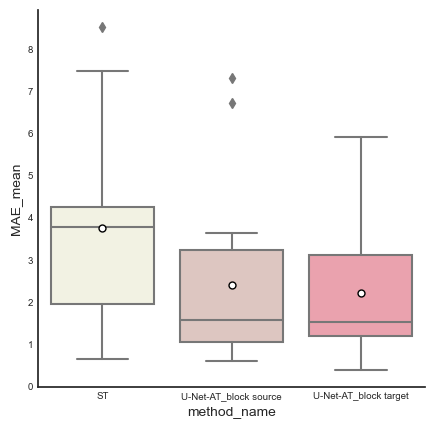

In [42]:
modaliy_mask = df_performance_agg_joint['modality']=='ECG-SR+PPG-select'


method_mask = df_performance_agg_joint['method']=='ST'
df1 = df_performance_agg_joint[(df_performance_agg_joint['TF_type']=='source')&method_mask&modaliy_mask].copy()
df1['method_name'] = 'ST'



method_name = 'U-Net-AT_block'
method_mask = df_performance_agg_joint['method']==method_name
df2 = df_performance_agg_joint[(df_performance_agg_joint['TF_type']=='source')&method_mask&modaliy_mask].copy()
df2['method_name'] = method_name + ' source'

# method_name1 = 'U-Net-AT_block'
method_mask = df_performance_agg_joint['method']==method_name
df3 = df_performance_agg_joint[(df_performance_agg_joint['TF_type']=='target')&method_mask&modaliy_mask].copy()
df3['method_name'] = method_name + ' target'

df = pd.concat([df1, df2, df3])

# list_methods = list(df['method_name'].unique())
fig_name='Fig6Xmod_{}_TFs'.format(act_type)

fig, ax = plt.subplots(1,1, figsize=(5*1,5),dpi=100)
fontsize=7

#     sns.violinplot(x="modality", y=metric_name, hue="TF_type", data=df, ax=ax, palette=TF_color_dict)
sns.boxplot(x='method_name', y='MAE_mean', data=df, ax=ax, palette=hue_color_dict,
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"5"},
           )
ax.tick_params(labelsize=fontsize)
ax_no_top_right(ax)



In [43]:
variable_name = 'method_name'
df_table_agg = df[['MAE_mean', variable_name, 'subject_id']].copy()
df_table_agg = df_table_agg.groupby(variable_name)["MAE_mean"].agg([np.mean, np.std]).T
df_table_agg

method_name,ST,U-Net-AT_block source,U-Net-AT_block target
mean,3.751925,2.411950,2.212351
std,2.404362,1.986454,1.664101


In [53]:
# activity_type

In [44]:
from scipy import stats

In [45]:
# rvs1.shape, rvs2.shape

In [46]:
def is_normal(x, debug=False):
    k2, p = stats.normaltest(x)
    alpha = 1e-3
    if debug:
        print("p = {:g}".format(p))
    # p = 8.4713e-19
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        if debug:
            print("The null hypothesis can be rejected")
        return False
    else:
        if debug:
            print("The null hypothesis cannot be rejected")
        return True

In [47]:
print('df1 is normal: {}\n'.format(is_normal(df1['MAE_mean'], debug=True) ) )
print('df2 is normal: {}\n'.format(is_normal(df2['MAE_mean'], debug=True) ) )
print('df3 is normal: {}\n'.format(is_normal(df3['MAE_mean'], debug=True) ) )


p = 0.366604
The null hypothesis cannot be rejected
df1 is normal: True

p = 0.00781454
The null hypothesis cannot be rejected
df2 is normal: True

p = 0.0403411
The null hypothesis cannot be rejected
df3 is normal: True



/home/mchan/miniconda3/envs/mienv/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


In [54]:
test_A = stats.ttest_rel(df1['MAE_mean'], df2['MAE_mean'])
print('p-value: {:.4f}'.format(test_A[1]))

p-value: 0.0026


In [48]:
test_A = stats.ttest_rel(df1['MAE_mean'], df3['MAE_mean'])
print('p-value: {:.4f}'.format(test_A[1]))

p-value: 0.0043


In [52]:
from scipy.stats import wilcoxon

# ttest_A = stats.ttest_rel(df1['MAE_mean'], df2['MAE_mean'])

test_B = wilcoxon(df1['MAE_mean'].values-df2['MAE_mean'].values)
# res.statistic, res.pvalue
print('p-value: {:.8f}'.format(test_B.pvalue))

p-value: 0.00001526


In [ ]:
# df3

In [ ]:
# df2

In [ ]:
from scipy import stats
rng = np.random.default_rng()
pts = 1000
a = rng.normal(0, 1, size=pts)
b = rng.normal(2, 1, size=pts)
x = np.concatenate((a, b))
k2, p = stats.normaltest(x)
alpha = 1e-3
print("p = {:g}".format(p))
# p = 8.4713e-19
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")
# The null hypothesis can be rejected

In [ ]:
# is_normal(b)

In [ ]:
plt.hist(x)